# Import 


In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet unet==0.7.7
%pip install --quiet torchio==0.18.90
%pip install --quiet torchvision
%pip install --quiet matplotlib

%matplotlib inline
!apt -qq install tree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.7/172.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.9 MB/s eta 0:00:00
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Selecting previously unselected package tree.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...


In [2]:
import torch
import torchio as tio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

import os

from google.colab import drive


import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import pandas as pd
import nibabel as nib


from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from skimage.segmentation import flood_fill
from skimage import measure




import cv2




# Open data


## Images

In [3]:
drive.mount('/content/drive')
train_data_path = '/content/drive/MyDrive/Colab Notebooks/Data/Train'


train_subjects = []
train_set = {}
for sub_dir in os.listdir(train_data_path):
    sub_dir_path = os.path.join(train_data_path, sub_dir)
    if os.path.isdir(sub_dir_path):
        label = int(sub_dir)
        subject = tio.Subject(
            ED=tio.ScalarImage(os.path.join(sub_dir_path, sub_dir+'_ED.nii')),
            ES=tio.ScalarImage(os.path.join(sub_dir_path, sub_dir+'_ES.nii')),
            ED_seg=tio.ScalarImage(os.path.join(sub_dir_path, sub_dir+'_ED_seg.nii')),
            ES_seg=tio.ScalarImage(os.path.join(sub_dir_path, sub_dir+'_ES_seg.nii')),
            label=label
        )
        train_subjects.append(subject)

        ed_path = os.path.join(sub_dir_path, sub_dir+'_ED.nii')
        ed_mask_path = os.path.join(sub_dir_path, sub_dir+'_ED_seg.nii')
        es_path = os.path.join(sub_dir_path, sub_dir+'_ES.nii')
        es_mask_path = os.path.join(sub_dir_path, sub_dir+'_ES_seg.nii')

        ed = nib.load(ed_path)
        ed_mask = nib.load(ed_mask_path)
        es = nib.load(es_path)
        es_mask = nib.load(es_mask_path)

        train_set[sub_dir] = [ed, ed_mask, es, es_mask]


dataset = tio.SubjectsDataset(train_subjects)


Mounted at /content/drive


In [4]:
test_data_path = '/content/drive/MyDrive/Colab Notebooks/Data/Test'


test_subjects = []
test_set = {}
for sub_dir in os.listdir(test_data_path):
    sub_dir_path = os.path.join(test_data_path, sub_dir)
    if os.path.isdir(sub_dir_path):
        label = int(sub_dir)
        subject = tio.Subject(
            ED=tio.ScalarImage(os.path.join(sub_dir_path, sub_dir+'_ED.nii')),
            ES=tio.ScalarImage(os.path.join(sub_dir_path, sub_dir+'_ES.nii')),
            ED_seg=tio.ScalarImage(os.path.join(sub_dir_path, sub_dir+'_ED_seg.nii')),
            ES_seg=tio.ScalarImage(os.path.join(sub_dir_path, sub_dir+'_ES_seg.nii')),
            label=label
        )
        test_subjects.append(subject)

        ed_path = os.path.join(sub_dir_path, sub_dir+'_ED.nii')
        ed_mask_path = os.path.join(sub_dir_path, sub_dir+'_ED_seg.nii')
        es_path = os.path.join(sub_dir_path, sub_dir+'_ES.nii')
        es_mask_path = os.path.join(sub_dir_path, sub_dir+'_ES_seg.nii')

        ed = nib.load(ed_path)
        ed_mask = nib.load(ed_mask_path)
        es = nib.load(es_path)
        es_mask = nib.load(es_mask_path)

        test_set[sub_dir] = [ed, ed_mask, es, es_mask]


dataset = tio.SubjectsDataset(test_subjects)


In [5]:
#Cette fonction permet de remettre les dictionnaires de données dans l'ordre, puisqu'ils ne le sont pas lors de la création. 
#De plus, cela permet d'avoir des clefs de type 'int' au lieu de 'str'
def order_dic(dic):

  indices = {}
  for id in dic:
    indices[int(id)] = id
  
  ordered_ind = sorted([int(k) for k in dic.keys()])

  ordered_dic = {}
  for k in ordered_ind:
    ordered_dic[k] = dic[indices[k]]


  return ordered_dic

In [6]:
train_set = order_dic(train_set)
test_set = order_dic(test_set)

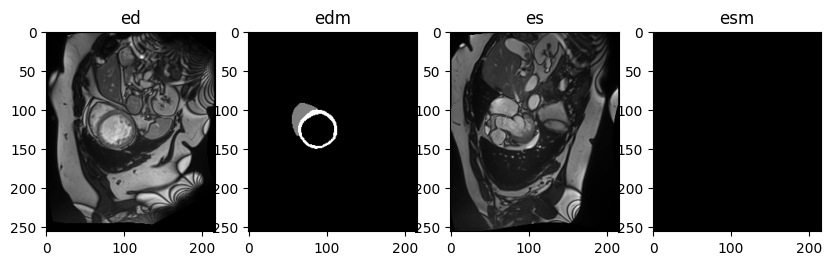

In [7]:

# Chaque img contient 10 images 

ed, edm, es, esm = test_set[101]
ed, edm, es, esm = ed.get_fdata(), edm.get_fdata(), es.get_fdata(), esm.get_fdata()

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes[0].imshow(ed[:, :, ed.shape[2] // 2 ], cmap='gray')
axes[0].set_title('ed')
axes[1].imshow(edm[:, :, edm.shape[2] // 2], cmap='gray')
axes[1].set_title('edm')
axes[2].imshow(es[:, :, 0], cmap='gray')
axes[2].set_title('es')
axes[3].imshow(esm[:, :, 0], cmap='gray')
axes[3].set_title('esm')
plt.show()


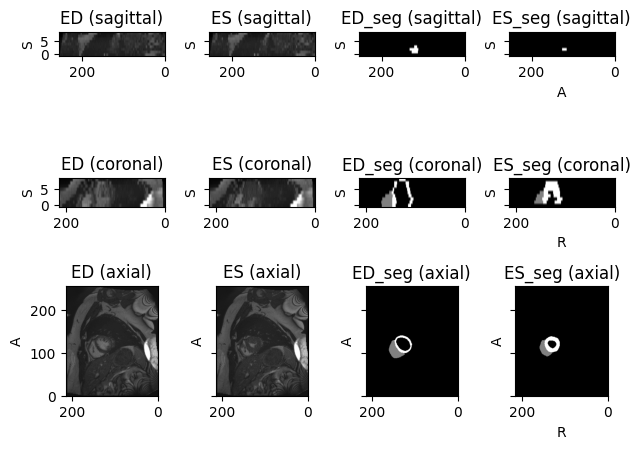

In [8]:
test_subjects[0].plot()

## Tables

In [9]:
training_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/metaDataTrain.csv')

In [10]:
training_data.head()

,Id,Category,Height,Weight
0,1,2,184.0,95.0
1,2,2,160.0,70.0
2,3,2,165.0,77.0
3,4,2,159.0,46.0
4,5,2,165.0,77.0


In [11]:
testing_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/metaDataTest.csv')

# Pre-processing


## Segmentation

In [12]:
def fill_missing_seg(mask1, mask2):
  '''
  mask : the 2*n masks corresponding to the same sample
  '''
  header1, header2 = mask1.header, mask2.header
  affine1, affine2 = mask1.affine, mask2.affine
  mask1, mask2 = mask1.get_fdata(), mask2.get_fdata()
  
  for i in range(mask1.shape[2]):
    m1, m2 = mask1[:,:,i], mask2[:,:,i]

    indices = np.argwhere(m1==2)
    if indices.shape[0] != 0:
      centerx = int(indices[:,0].sum()/indices.shape[0])
      centery = int(indices[:,1].sum()/indices.shape[0])
      mask1[:,:,i] = flood_fill(m1, (centerx, centery), 3)

    indices = np.argwhere(m2==2)
    if indices.shape[0] != 0:   
      centerx = int(indices[:,0].sum()/indices.shape[0])
      centery = int(indices[:,1].sum()/indices.shape[0])
      mask2[:,:,i] = flood_fill(m2, (centerx, centery), 3)

  return nib.Nifti1Image(mask1, affine=affine1, header=header1), nib.Nifti1Image(mask2, affine=affine2, header=header2)

In [13]:
for id, set in test_set.items():
  set[1], set[3] = fill_missing_seg(set[1], set[3])

## Finding features

### BMI

In [14]:
def get_table_features(data):
  '''
  x : training_data table
  '''
  x = data[['Height', 'Weight']].to_numpy()
  bmi = x[:,1] / (x[:,0]**2)
  return np.concatenate((x, bmi.reshape((x.shape[0],1))), axis=1)
  

In [15]:
table_feat_train = get_table_features(training_data)
table_feat_test = get_table_features(testing_data)

### Volumes

In [16]:
#On trouve les volumes des différentes zones en calculant le nombre de pixels pour chaque catégorie dans les masques. 
#On utilise le '.header.get_zooms' afin d'avoir le volume "réel", et éviter les problèmes d'échelle entre les différentes images.
def get_volume_feature(data_set):

  n = len(data_set)
  feat = np.zeros((n,6))
  i=0
  for id, set in data_set.items():
    
    edm, esm = set[1], set[3]
    size_d, size_s = set[1].header.get_zooms(), set[3].header.get_zooms()
    vol_d, vol_s = size_d[0]*size_d[1]*size_d[2], size_s[0]*size_s[1]*size_s[2]

    nbr1_d, nbr2_d, nbr3_d = (edm.get_fdata()[:,:,:] == 1).sum(), (edm.get_fdata()[:,:,:] == 2).sum(), (edm.get_fdata()[:,:,:] == 3).sum()
    nbr1_s, nbr2_s, nbr3_s = (esm.get_fdata()[:,:,:] == 1).sum(), (esm.get_fdata()[:,:,:] == 2).sum(), (esm.get_fdata()[:,:,:] == 3).sum()

    vol1_d, vol2_d, vol3_d = nbr1_d * vol_d, nbr2_d * vol_d, nbr3_d * vol_d
    vol1_s, vol2_s, vol3_s = nbr1_s * vol_s, nbr2_s * vol_s, nbr3_s * vol_s
    feat[i,:] = vol1_d, vol2_d, vol3_d, vol1_s, vol2_s, vol3_s 
    i +=1

  return feat

In [17]:
vol_feat_train = get_volume_feature(train_set)
vol_feat_test = get_volume_feature(test_set)

### Ratios



In [18]:
#On utilise les volumes obtenus grâce à la fonction précédente pour calculer des rapports.
def get_ratios_features(vol_feat):

  feat = np.zeros((vol_feat.shape[0], 3))

  vol1_d, vol2_d, vol3_d, vol1_s, vol2_s, vol3_s = vol_feat[:,0], vol_feat[:,1], vol_feat[:,2], vol_feat[:,3], vol_feat[:,4], vol_feat[:,5]
  
  ratD = vol1_d / vol3_d
  ratS = vol2_s / vol3_s
  ef = ((vol1_d + vol2_d) - (vol1_s + vol2_s)) / (vol1_d + vol2_d)

  feat[:,0], feat[:,1], feat[:,2] = ratD, ratS, ef

  return feat

In [19]:
rat_feat_train = get_ratios_features(vol_feat_train)
rat_feat_test = get_ratios_features(vol_feat_test)

### Geometrical properties

In [20]:
#On calcule ici la circonférence et la circularité des différentes parties (en sommant celles de chaques tranches 2D)
def get_geo_features(data_set):

  n = len(data_set)
  feat = np.zeros((n,12))

  k=0

  for id, set in data_set.items():

    edm, esm = set[1], set[3]
    size_d, size_s = set[1].header.get_zooms(), set[3].header.get_zooms()
    surf_d, surf_s = size_d[0]*size_d[1], size_s[0]*size_s[1]

    #nombre de pixels dans la zone concercée
    nbr1_d, nbr2_d, nbr3_d = (edm.get_fdata()[:,:,:] == 1).sum(), (edm.get_fdata()[:,:,:] == 2).sum(), (edm.get_fdata()[:,:,:] == 3).sum()
    nbr1_s, nbr2_s, nbr3_s = (esm.get_fdata()[:,:,:] == 1).sum(), (esm.get_fdata()[:,:,:] == 2).sum(), (esm.get_fdata()[:,:,:] == 3).sum()

    area1_d, area2_d, area3_d = nbr1_d*surf_d, nbr2_d*surf_d, nbr3_d*surf_d
    area1_s, area2_s, area3_s = nbr1_s*surf_s, nbr2_s*surf_s, nbr3_s*surf_s

    edm, esm = edm.get_fdata(), esm.get_fdata()

    contours1_d, contours2_d, contours3_d, contours1_s, contours2_s, contours3_s = 0,0,0,0,0,0

    for i in range(edm.shape[2]):
      #On obtient les contours avec un gradient, on multiplie par la taille pour garder l'invariance à la taille par pixels
      contours1_d += cv2.morphologyEx((edm[:,:,i]==1).astype(np.uint8), cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))).sum() *surf_d
      contours2_d += cv2.morphologyEx((edm[:,:,i]==2).astype(np.uint8), cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))).sum() *surf_d
      contours3_d += cv2.morphologyEx((edm[:,:,i]==3).astype(np.uint8), cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))).sum() *surf_d

      contours1_s += cv2.morphologyEx((edm[:,:,i]==1).astype(np.uint8), cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))).sum() *surf_s
      contours2_s += cv2.morphologyEx((edm[:,:,i]==2).astype(np.uint8), cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))).sum() *surf_s
      contours3_s += cv2.morphologyEx((edm[:,:,i]==3).astype(np.uint8), cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))).sum() *surf_s

    feat[k,0], feat[k,1], feat[k,2], feat[k,3], feat[k,4], feat[k,5] = contours1_d, contours2_d, contours3_d, contours1_s, contours2_s, contours3_s

    circ1_d, circ2_d, circ3_d = 4* np.pi * area1_d / (contours1_d **2), 4* np.pi * area2_d / (contours2_d **2), 4* np.pi * area3_d / (contours3_d **2)
    circ1_s, circ2_s, circ3_s = 4* np.pi * area1_s / (contours1_s **2), 4* np.pi * area2_s / (contours2_s **2), 4* np.pi * area3_s / (contours3_s **2)

    feat[k,6], feat[k,7], feat[k,8], feat[k,9], feat[k,10], feat[k,11] = circ1_d, circ2_d, circ3_d, circ1_s, circ2_s, circ3_s

    k+=1

  return feat

In [21]:
geo_feat_train = get_geo_features(train_set)
geo_feat_test = get_geo_features(test_set)

### Global features

In [22]:
#On cherche la taille des différentes parties (leur volume) par rapport à la taille du patient. On utilise pour cela les caractéristiques de volume.
def get_glob_features(vol_feat, data):
  x = data['Height'].to_numpy().reshape((vol_feat.shape[0], 1))
  vol1, vol2, vol3 = (vol_feat[:,0] + vol_feat[:,1])/2, (vol_feat[:,2] + vol_feat[:,3])/2, (vol_feat[:,4] + vol_feat[:,5])/2,
  feat = np.zeros((vol_feat.shape[0],3))
  feat[:,0], feat[:,1], feat[:,2] = vol1/x[:,0], vol2/x[:,0], vol3/x[:,0]

  return feat

In [23]:
glob_feat_train = get_glob_features(vol_feat_train, training_data)
glob_feat_test = get_glob_features(vol_feat_test, testing_data)

### Myocardium Thickness

In [24]:

def get_thick_features(dataset):

  feat = np.zeros((len(dataset),2))
  k=0

  prob = []

  for id,set in dataset.items():

    edm, esm = set[1].get_fdata(), set[3].get_fdata()

    size_d, size_s = set[1].header.get_zooms(), set[3].header.get_zooms()
    size_d, size_s = np.sqrt(size_d[0]**2+size_d[1]**2), np.sqrt(size_s[0]**2+size_s[1]**2)
    
    edm, esm = edm[:,:,edm.shape[2]//2], esm[:,:,esm.shape[2]//2]

    edm, esm = (edm==2), (esm==2)
    edmC, esmC = cv2.morphologyEx(edm.astype(np.uint8), cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))), cv2.morphologyEx(esm.astype(np.uint8), cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))
    labD, labS = measure.label(edmC), measure.label(esmC)

    i=- set[1].get_fdata().shape[2]//2

    while ((not (labS==2).any() or not (labD==2).any()) and i != (set[1].get_fdata().shape[2]//2)) :
      #On cherche un tranche 2D telle qu'il est possible par transformation morphologique d'obtenir le contour extérieur et intérieur du myocarde. 
      #Si l'épaisseur est trop faible par endroit, il est impossible de les différencier. 
      
      #On parcourt les différentes tranches, et si aucune n'est satisfaisante, on stocke l'indice de l'image, que l'on calculera grâce à la fonction suivante.
      edm, esm = set[1].get_fdata(), set[3].get_fdata()
      edm, esm = edm[:,:,edm.shape[2]//2 +i], esm[:,:,esm.shape[2]//2 +i]
      edm, esm = (edm==2), (esm==2)
      edmC, esmC = cv2.morphologyEx(edm.astype(np.uint8), cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))), cv2.morphologyEx(esm.astype(np.uint8), cv2.MORPH_GRADIENT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)))
      labD, labS = measure.label(edmC), measure.label(esmC)

      i+=1

    if i != (set[1].get_fdata().shape[2]//2):
      b, s = (labD==1), (labD==2)
      indB, indS = np.argwhere(b), np.argwhere(s)
      minRb, minRs, minCb, minCs = np.min(indB[:,0]),  np.min(indS[:,0]),  np.min(indB[:,1]),  np.min(indS[:,1])
      maxRb, maxRs, maxCb, maxCs = np.max(indB[:,0]),  np.max(indS[:,0]),  np.max(indB[:,1]),  np.max(indS[:,1])

      dminD, dmaxD = np.sqrt(np.abs(minRb-minRs)**2 + np.abs(minCb-minCs)**2 )* size_d, np.sqrt(np.abs(maxRb-maxRs)**2 + np.abs(maxCb-maxCs)**2 )* size_d
      thickD =( dminD+dmaxD) /2

      b, s = (labS==1), (labS==2)
      indB, indS = np.argwhere(b), np.argwhere(s)
      minRb, minRs, minCb, minCs = np.min(indB[:,0]),  np.min(indS[:,0]),  np.min(indB[:,1]),  np.min(indS[:,1])
      maxRb, maxRs, maxCb, maxCs = np.max(indB[:,0]),  np.max(indS[:,0]),  np.max(indB[:,1]),  np.max(indS[:,1])

      dminS, dmaxS = (np.abs(minRb-minRs) + np.abs(minCb-minCs) )/2 * size_s, (np.abs(maxRb-maxRs) + np.abs(maxCb-maxCs) )/ 2 * size_s
      
      thickS =( dminS+dmaxS) /2

      feat[k,0], feat[k,1] = thickD, thickS

    else:
      prob.append(k)

    k+=1

  return feat, prob

In [25]:
def naive_thick_features(dataset, index, feat):

  k=0

  for id,set in dataset.items():

    if k in index: #Cela correspond au cas problématiques dans la fonction précédente.
      
      edm, esm = set[1].get_fdata(), set[3].get_fdata()

      size_d, size_s = set[1].header.get_zooms(), set[3].header.get_zooms()
      
      edm, esm = edm[:,:,edm.shape[2]//2], esm[:,:,esm.shape[2]//2]

      edm, esm = (edm==2), (esm==2)
      indD, indS = np.argwhere(edm), np.argwhere(esm)
      mD, mS = np.mean(indD, axis=0), np.mean(indS, axis=0)
      rowD, colD = int(mD[0]), int(mD[1])
      rowS, colS = int(mS[0]), int(mS[1])
      
      #Il s'agit d'un calcul de circonférence naif et complexe, c'est pour ça que l'on ne l'effectue que sur les images problématiques.
      compt = np.zeros(4)
      i=0
      rowDh, rowDb = rowD, rowD
      colDg, colDd = colD, colD
      DistD = np.zeros(4)
      rowSh, rowSb = rowS, rowS
      colSg, colSd = colS, colS
      DistS = np.zeros((4))
      while(compt.sum() != 8):
        
        if( compt[0]!=2):
          rowDh+= 1
          rowDb-= 1
          if edm[rowDh,colD] and compt[0]==0:
            DistD[0] = rowDh
            DistD[1] = rowDb
            compt[0]+=1
          if (not edm[rowDh, colD]) and compt[0]==1:
            DistD[0] = np.abs(DistD[0] - rowDh)
            DistD[1] = np.abs(DistD[1] - rowDb)
            compt[0]+=1

        if( compt[1]!=2):
          colDg+= 1
          colDd-= 1
          if edm[rowD,colDd] and compt[1]==0:
            DistD[2] = colDg
            DistD[3] = colDd
            compt[1]+=1
          if (not edm[rowD, colDd])and compt[1]==1:
            DistD[2] = np.abs(DistD[0] - colDg)
            DistD[3] = np.abs(DistD[1] - colDd)
            compt[1]+=1
          
        if( compt[2]!=2):
          rowSh+= 1
          rowSb-= 1
          if esm[rowSh,colS] and compt[2]==0:
            DistS[0] = rowSh
            DistS[1] = rowSb
            compt[2]+=1
          if (not esm[rowSh, colS])and compt[2]==1:
            DistS[0] = np.abs(DistS[0] - rowSh)
            DistS[1] = np.abs(DistS[1] - rowSb)
            compt[2]+=1

        if( compt[3]!=2):
          colSd+= 1
          colSg-= 1
          if esm[rowS,colSd] and compt[3]==0:
            DistS[2] = colSg
            DistS[3] = colSd
            compt[3]+=1
          if (not esm[rowS, colSd])and compt[3]==1:
            DistS[2] = np.abs(DistS[0] - colSg)
            DistS[3] = np.abs(DistS[1] - colSd)
            compt[3]+=1
        i+=1

      DistD = DistD * np.array([size_d[1],size_d[1], size_d[0], size_d[0]])
      DistS = DistS * np.array([size_s[1],size_s[1], size_s[0], size_s[0]])
      feat[k,0], feat[k,1] = np.mean(DistD), np.mean(DistS)

    k+=1

  return feat

In [26]:
thick_feat_train, p = get_thick_features(train_set)
thick_feat_test, pp = get_thick_features(test_set)


In [27]:
thick_feat_train = naive_thick_features(train_set, p, thick_feat_train)
thick_feat_test = naive_thick_features(test_set, pp, thick_feat_test)

# Processing

In [32]:
class_names = ["Healthy Control","Myocardial infarction", "Dilated Cardiomyopathy", "Hypertrophic Cardiomyopathy", "Abnormal Right Ventricle"] # y=0, y=1 etc
feature_names = ["Height", "Weight", "BMI", "Diastole Volume Right Ventricule Cavity", "Diastole Volume Myocardium", "Diastole Volume Left Ventricule Cavity",
                "6Systole Volume Right Ventricule Cavity", "Systole Volume Myocardium", "Systole Volume Left Ventricule Cavity",
                 "9Ratio D", "Ratio S", "Ejection Fraction", 
                 "12Perimeter RV at D", "Perimeter M at D", "Perimeter LV at D", "Perimeter RV at S", "Perimeter M at S", "Perimeter LV at S",
                 "18Circularity RV at D", "Circularity M at D", "Circularity LV at D", "Circularity RV at S", "Circularity M at S", "Circularity LV at S",
                 "24Ratio RV vol/height", "Ratio M vol/height", "Ratio LV vol/height",
                 "27Myocardium thickness at D", "Myocardium thickness at S"]

In [30]:
X_train, y_train = np.concatenate(( table_feat_train, vol_feat_train, rat_feat_train, geo_feat_train, glob_feat_train, thick_feat_train,) ,axis=1), training_data['Category'].to_numpy()

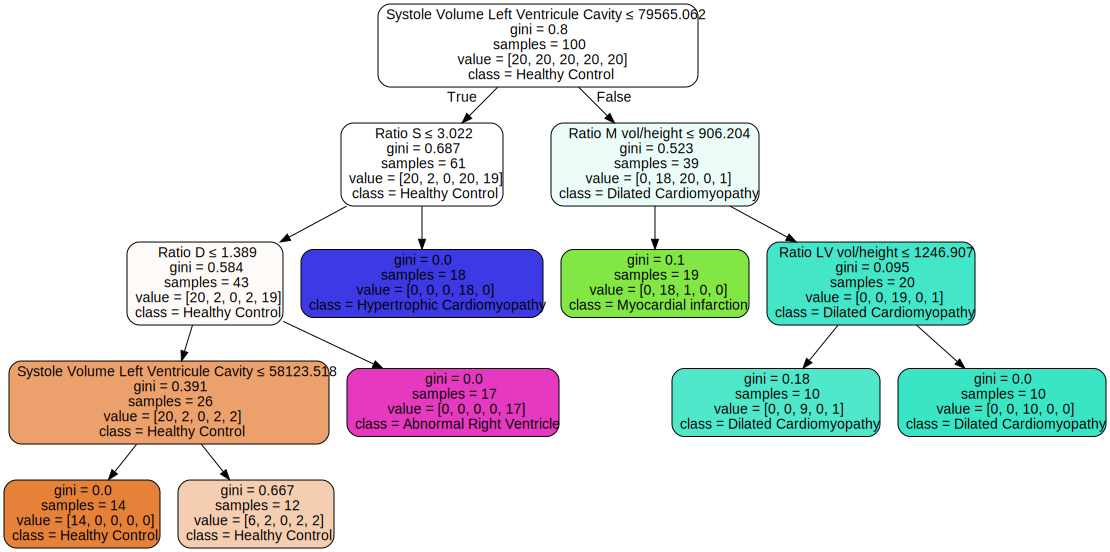

In [33]:
import graphviz 

Tree = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=10,random_state=0)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)

dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=feature_names ,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [36]:
#On choisit les features les plus utiles (celles utilisées dans l'arbre)
def selected_feature(nbr, index, x):
  new = np.zeros((x.shape[0], nbr))
  for ind, j in enumerate(index):
    new[:,ind] = x[:, j]
  return new

In [37]:
X_new = selected_feature(5, [8,9,10,25,26], X_train) #J'ai oublié de l'utiliser ...

In [38]:
y = training_data['Category'].to_numpy()
x = np.concatenate( (glob_feat_train, thick_feat_train, table_feat_train[:,2].reshape(100,1), vol_feat_train, rat_feat_train), axis=1 )

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify= y)

In [40]:
xt = np.concatenate( (glob_feat_test, thick_feat_test, table_feat_test[:,2].reshape(50,1), vol_feat_test, rat_feat_test), axis=1 )

In [41]:
#Pour réduire le nombre de caractéristiques, s'est avéré peu efficace.
pca = PCA(n_components=12)
pca.fit(X_train)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

pca = PCA(n_components=12)
pca.fit(x)
x_pca = pca.transform(x)
xt_pca = pca.transform(xt)

In [42]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [50,60,70,80,90,100], 'min_samples_leaf': [6,7,8,9,10], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.8648351648351648
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 70}
Random Forest test score : 0.9090909090909091


In [43]:
RF = RandomForestClassifier(n_estimators=grid_RF.best_params_['n_estimators'],
                            min_samples_leaf=grid_RF.best_params_['min_samples_leaf'],
                            max_features=grid_RF.best_params_['max_features'],
                            random_state=0)
RF.fit(x, y.ravel())
y_pred = RF.predict(xt)

# Results

In [44]:
dictionnary = {'Id' : np.arange(101,151,1), 'Category' : y_pred}
SampleSubmission = pd.DataFrame(dictionnary)
SampleSubmission.to_csv('SampleSubmission.csv', index=False)